# CS4487 - Machine Learning
# Lecture 6b - Unsupervised Learning - Clustering
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Unsupervised Learning
2. Parametric clustering
    1. K-means
    2. Gaussian mixture models (GMMs)
    3. Dirichlet Process GMMs
3. **Non-parametric clustering and Mean-shift**
4. Spectral clustering

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
random.seed(38)
mu1 = array([0,0])
mu2 = array([6,8])
st1 = 2*random.normal(0,1,(2,2))
st2 = 2*random.normal(0,1,(2,2))
X1 = dot(random.normal(0,1,[60, 2]), st1.T) + mu1
X2 = dot(random.normal(0,1,[60, 2]), st2.T) + mu2
Xfull = r_[X1,X2]
axboxfull = [-10, 20, -7, 20]

X = Xfull
axbox = axboxfull

In [3]:

mycmap = matplotlib.colors.ListedColormap(["#FF0000", "#00FF00", "#0000FF"])
cols = ['r', 'g', 'b']
jet = plt.get_cmap('jet')
rbow = plt.get_cmap('rainbow')

al = 0.4
rbow_data2 = {
    'red': lambda x:   (1-al) + al*abs(2 * x - 0.5),
    'green': lambda x: (1-al) + al*sin(x * pi),
    'blue': lambda x:  (1-al) + al*cos(x * pi / 2),
} 
rbow2 = matplotlib.colors.LinearSegmentedColormap('rainbow2', rbow_data2)

# ax is the axis
# cmap is colormap to use
# cl is the index of components to show [default is None which means all components]
def make_ellipses(means, covars, ax, cmap, cl=None):
    dim = means.shape[1]
    if cl is None:
        cl = range(means.shape[0])
    for n in cl:
        mycv = covars[n]
        if mycv.size==1:
            mycv = mycv*eye(dim)
        elif mycv.size==dim:
            mycv = diag(mycv)
            
        v, w = linalg.eigh(mycv)

        u = w[0] / linalg.norm(w[0])
        angle = arctan2(u[1], u[0])
        angle = 180 * angle / pi  # convert to degrees
        s   = sqrt(v)  # stddev
        
        for f in [1,2,3]:
            ss = s*f  
            ell = matplotlib.patches.Ellipse(means[n, :2], 2*ss[0], 2*ss[1],
                                      180 + angle, color=cmap(float(n)/max(max(cl),1)))
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.15)
            ax.add_artist(ell)

def plot_clusters(model, axbox, X, Y, pcmap, ccmap, showregions=False):
    # model = kmeans, gmm, dpgmm
    # X = points
    # pcmap = colormap for points
    # ccmap = colormap for centers
    
    name = model.__class__.__name__
    
    if (name == 'KMeans'):
        cc = model.cluster_centers_
        cl = range(model.n_clusters)
        cv = None
    elif (name == 'GMM') or (name == 'GaussianMixture'):
        cc = model.means_
        cl = range(model.n_components)
        cv = model.covariances_
    elif (name == 'DPGMM') or (name == 'BayesianGaussianMixture'):
        cl = unique(Y)        # find active clusters
        cc = model.means_[cl] # get means
        cv = model.covariances_[cl]
    elif (name == 'VBGMM'):
        cl = unique(Y)        # find active clusters
        cc = model.means_[cl] # get means
        cv = None
    elif (name == 'MeanShift'):
        cc = model.cluster_centers_
        cl = range(len(cc))
        cv = None
    elif (name == 'SpectralClustering'):
        cc = None
        cl = range(model.n_clusters)
        cv = None
    elif (name == 'DBSCAN'):
        cc = None
        cv = None
        cl = unique(model.labels_)
        cl = cl[cl != -1]
        core_mask = zeros_like(Y, dtype=bool)
        core_mask[model.core_sample_indices_] = True
        outlier_mask = (Y == -1)
        noncore_mask = logical_not(core_mask) & logical_not(outlier_mask)
        
    if showregions:    
        dx = axbox[1]-axbox[0]
        dy = axbox[3]-axbox[2]
        
        axbox2 = [ axbox[0]-0.5*dx, axbox[1]+0.5*dx,
                   axbox[2]-0.5*dy, axbox[3]+0.5*dy]
        
        # grid of points
        xr = [linspace(axbox2[0],axbox2[1],300), 
              linspace(axbox2[2],axbox2[3],300)]
        xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
        allpts = c_[xgrid0.ravel(), xgrid1.ravel()]
        
        # predictions
        Ypred = model.predict(allpts).reshape(xgrid0.shape)
        
        plt.imshow(Ypred, origin='lower', extent=axbox2, aspect='auto', 
           vmin=min(cl), vmax=max(cl), alpha=0.2, cmap=pcmap)

    # show ellipses
    if (cv is not None) and (not showregions):  
        make_ellipses(cc, cv, plt.gca(), pcmap, None)
    
    # show points
    if X is not None:
        if (name == 'DBSCAN'):
            plt.scatter(X[core_mask,0], X[core_mask,1], c=Y[core_mask], cmap=pcmap, label='core points', edgecolors='k')
            plt.scatter(X[noncore_mask,0], X[noncore_mask,1], c=Y[noncore_mask], 
                        cmap=pcmap, label='border points',
                        vmin=min(cl), vmax=max(cl), marker='v', edgecolors='k')
            plt.scatter(X[outlier_mask,0], X[outlier_mask,1], color='k', label='noise', s=6, edgecolors='k') 
        else:
            plt.scatter(X[:,0], X[:,1], c=Y, cmap=pcmap, edgecolors='k')
    
    # show centers
    if cc is not None:
        plt.scatter(cc[:,0], cc[:,1], c=cl, s=250, cmap=ccmap, marker='*', edgecolors='k')

    plt.axis('equal');  plt.axis(axbox);  plt.grid(True)  
        
    # return number of clusters found
    return (len(cl),)

# Mean-shift algorithm
- Clustering algorithm that also automatically selects the number of clusters.
- **Idea:** iteratively shift towards the largest concentration of points.
  - start from an initial point $\mathbf{x}$ (e.g., one of the data points).
  - repeat until $\mathbf{x}$ is unchanged:
    - 1) find the nearest neighbors to $\mathbf{x}$ within some radius (bandwidth)
    - 2) set $\mathbf{x}$ to be the mean of the neighbor points.

In [4]:
X = Xfull
x0 = X[3,:]-array([-2,0])    

efigs = []
for i in range(8):
    if i % 2 == 0:
        efigs.append(plt.figure(figsize=(10,4)))

    # need to use the function version which can set the number of iterations
    cc,cl = cluster.mean_shift(X, bandwidth=3, max_iter=0, seeds=[x0])

    plt.subplot(1,2,i%2+1)
    plt.scatter(X[:,0], X[:,1], c='b', edgecolors='k')
    plt.plot(x0[0],x0[1], 'ro', label='old x')
    circ = plt.Circle(x0, radius=3, color='r', alpha=0.2, label='neighborhood')
    plt.gca().add_patch(circ)
    plt.plot(cc[0,0],cc[0,1], 'co', label='new x')
    if (linalg.norm(x0-cc[0,:])>0.1):
        plt.arrow(x0[0], x0[1], cc[0,0]-x0[0], cc[0,1]-x0[1], 
                  width=0.1, length_includes_head=True, head_width=0.4, color='r')
    plt.axis('equal'); plt.grid(True)
    plt.title('iteration ' + str(i))
    if i==0:
        plt.legend(loc=0, fontsize=9)
    
    x0 = cc[0,:]
    
    if i%2 == 1:
        plt.close()

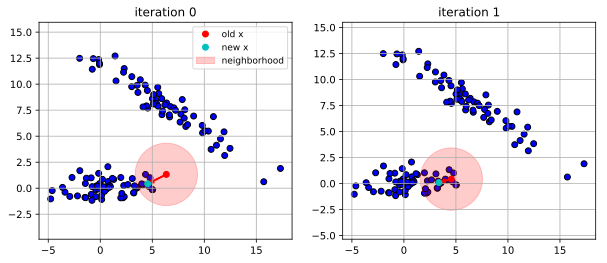

In [5]:
efigs[0]

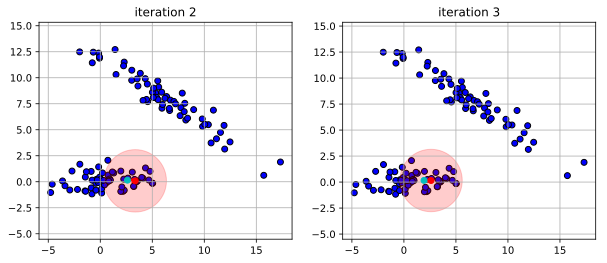

In [6]:
efigs[1]

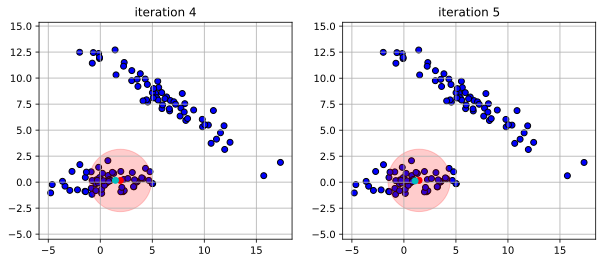

In [7]:
efigs[2]

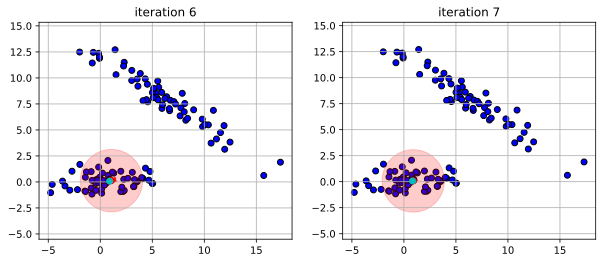

In [8]:
efigs[3]

# Getting the clusters
- Run the mean-shift algorithm for many initial points $\{x_i\}$.
  - the set of converged points contain the cluster centers.
    - need to remove the duplicate centers.
  - data points that converge to the same center belong to the same cluster.
  - different initializations can run in parallel (`n_jobs`)

(2,)

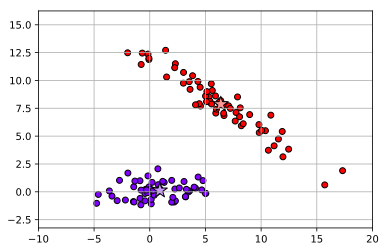

In [9]:
# bin_seeding=True -- coarsely uses data points as initial points
ms = cluster.MeanShift(bandwidth=5, bin_seeding=True, n_jobs=-1)
Y = ms.fit_predict(X)

cc = ms.cluster_centers_  # cluster centers

plot_clusters(ms, axbox, X, Y, rbow, rbow2)

- Cluster partitions
  - assign point based on convergence to same cluster center

(2,)

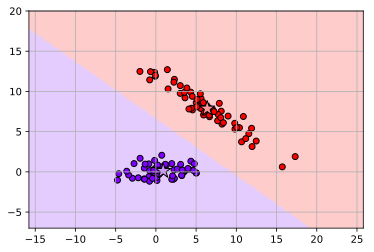

In [10]:
plot_clusters(ms, axbox, X, Y, rbow, rbow2, showregions=True)

# Number of clusters
- Number of clusters is implicitly controlled by the bandwidth (radius of the nearest-neighbors)
  - larger bandwidth creates less clusters
    - focuses on global large groups
  - smaller bandwidth creates more clusters
    - focuses on local groups.

In [11]:
msfig = plt.figure(figsize=(10,6))
for i,bw in enumerate([2, 3, 5, 10]):
    ms = cluster.MeanShift(bandwidth=bw, bin_seeding=True)
    Y = ms.fit_predict(X)

    plt.subplot(2,2,i+1)
    plot_clusters(ms, axbox, X, Y, rbow, rbow2)
    plt.title('bandwidth={}; {} clusters'.format(bw,len(ms.cluster_centers_)))
plt.close()

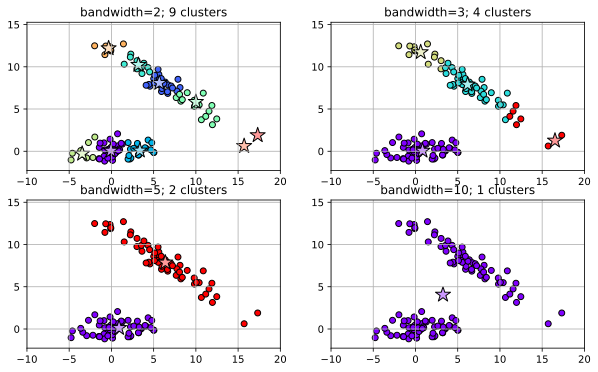

In [12]:
msfig

- Cluster partitions
  - assign points based on convergece to same cluster center.

In [13]:
msfig = plt.figure(figsize=(10,6))
for i,bw in enumerate([2, 3, 5, 10]):
    ms = cluster.MeanShift(bandwidth=bw, bin_seeding=True)
    Y = ms.fit_predict(X)

    plt.subplot(2,2,i+1)
    plot_clusters(ms, axbox, X, Y, rbow, rbow2, showregions=True)
    plt.title('bandwidth={}; {} clusters'.format(bw,len(ms.cluster_centers_)))
plt.close()

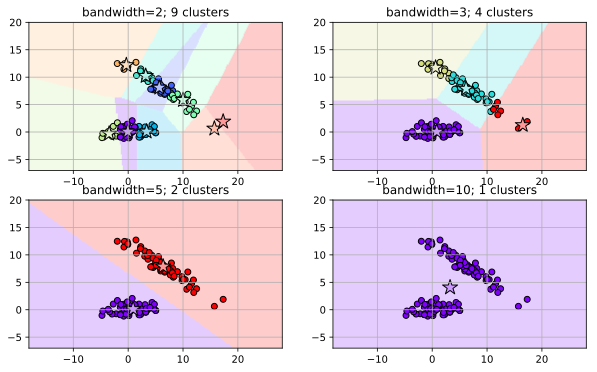

In [14]:
msfig

# Non-compact clusters
- K-means, GMM, and Mean-Shift assume that all clusters are compact.
  - i.e., circles or ellipses
- What about clusters of other shapes?
  - e.g., clusters not defined by compact distance to a "center"

In [15]:
random.seed(200)
X1 = 0.2*random.normal(0,1,[50, 2])
X1[:,1] *= 8
X1[:,0] += 0.3*power(X1[:,1],2) - 5

X2 = 0.4*random.normal(0,1,[50,2])-array([2,0])
X3 = 0.4*random.normal(0,1,[50,2])+array([2,0])

X4 = 0.2*random.normal(0,1,[50, 2])
X4[:,1] *= 8
X4[:,0] -= 0.3*power(X4[:,1], 2) - 5

Xtie = r_[X1,X2,X3,X4]
axboxtie = [-6, 6, -6, 6]

X = Xtie
axbox = axboxtie

km = cluster.KMeans(n_clusters=4, random_state=1234)
km.fit(X)

gmmf = mixture.GaussianMixture(n_components=4, covariance_type='full', random_state=4487, n_init=10)
gmmf.fit(X)

ms = cluster.MeanShift(bandwidth=2, bin_seeding=True)
ms.fit(X)

tiefig = plt.figure(figsize=(8,7))
plt.subplot(2,2,1)
plt.scatter(X[:,0], X[:,1], c='b', edgecolors='k')
plt.axis(axbox)
plt.grid(True)
plt.title('data')

for i,m in enumerate([km, gmmf, ms]):
    plt.subplot(2,2,i+2)
    Y = m.predict(X)
    plot_clusters(m, axbox, X, Y, rbow, rbow2)
    plt.grid(True)
    plt.title(m.__class__.__name__)
plt.close()

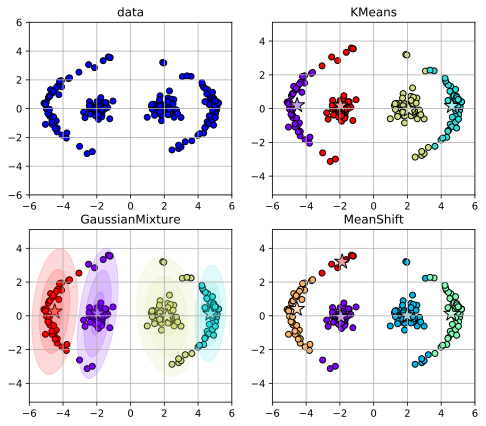

In [16]:
tiefig

In [17]:
Xcirc,Y = datasets.make_circles(n_samples=300, noise=0.05, factor=0.2)
axboxcirc = [-1.5, 1.5, -1.5, 1.5]

X = Xcirc
axbox = axboxcirc

km = cluster.KMeans(n_clusters=2, random_state=1234)
km.fit(X)

gmmf = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=4487, n_init=10)
gmmf.fit(X)

ms = cluster.MeanShift(bandwidth=0.5, bin_seeding=True)
ms.fit(X)

circfig = plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.scatter(X[:,0], X[:,1], c='b', edgecolors='k')
plt.grid(True); plt.axis(axbox)
plt.title('data')

for i,m in enumerate([km, gmmf, ms]):
    plt.subplot(2,2,i+2)
    Y = m.predict(X)
    plot_clusters(m, axbox, X, Y, rbow, rbow2)
    plt.grid(True)
    plt.title(m.__class__.__name__)
plt.close()

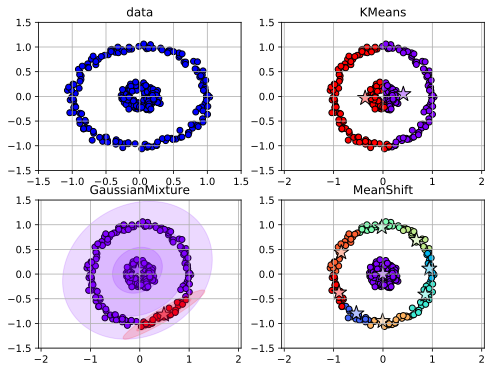

In [18]:
circfig

# Spectral Clustering
- Estimate the clusters using the pair-wise affinity between points.
- Affinity (similarity) between points 
  - kernel function: $k(\mathbf{x}_i,\mathbf{x}_j)$ -- RBF kernel
  - number of nearest neighbors within a radius (bandwidth)

In [19]:
X = Xtie
axbox = axboxtie

sc = cluster.SpectralClustering(n_clusters=4, affinity='rbf', gamma=1.0, assign_labels='discretize', n_jobs=-1)
Y = sc.fit_predict(X)  # cluster and also return the labels Y

cl = sc.labels_  # labels for each X
ii = random.permutation(len(cl))

afig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c='b', edgecolors='k')
plt.title('Data'); plt.grid(True); plt.axis(axbox)

plt.subplot(1,2,2)
plt.imshow(sc.affinity_matrix_[ix_(ii,ii)], interpolation='nearest', cmap='jet')
plt.title('affinity matrix')
plt.xlabel('data point index'); plt.ylabel('data point index')
plt.close()

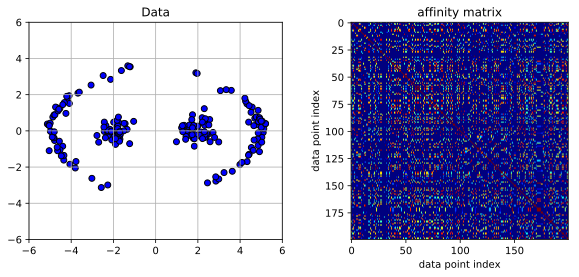

In [20]:
afig

# Spectral Clustering
- **Idea:** clustering with a graph formulation
  - each data point is a node in a graph
  - edge weight between two nodes is the affinity $k(\mathbf{x}_i,\mathbf{x}_j)$
    - (darker colors indicate stronger weights)

In [21]:
def plot_sc_graph(X, gamma, axbox):
    Xlen = X.shape[0]
    # calculate kernel
    K = metrics.pairwise.rbf_kernel(X, gamma=gamma)

    # graph figure
    for i in range(Xlen):
        for j in range(i+1,Xlen):
            if (K[i,j] > 0.01):
                plt.plot([X[i,0], X[j,0]], [X[i,1], X[j,1]], 
                         color=0.95*(1-K[i,j])*ones(3), zorder=K[i,j])
    # plot points
    plt.scatter(X[:,0], X[:,1], zorder=2, c='r', edgecolors='k')
    plt.axis(axbox); plt.grid(True)
    
    
X = Xtie[::2,:]
graphfig = plt.figure()
plot_sc_graph(X, 1.0, axbox)
plt.close()

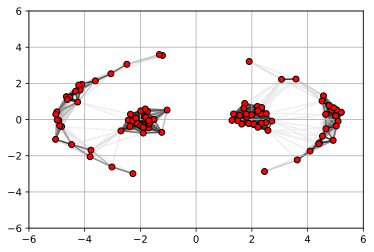

In [22]:
graphfig

- **Goal:** cut the graph into clusters such that weights of cut edges is small compared to the total edge weight within each cluster.
  - find "blocks" of high affinity in the affinity matrix.

In [23]:
X = Xtie
axbox = axboxtie


In [24]:
# spectral clustering
# rbf affinity
sc = cluster.SpectralClustering(n_clusters=4, affinity='rbf',
                                gamma=1.0, assign_labels='discretize', n_jobs=-1)
Y = sc.fit_predict(X)

In [25]:
ii = argsort(Y)
scfig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(sc.affinity_matrix_[ix_(ii,ii)], interpolation='nearest', cmap='jet')
plt.title('sorted affinity matrix')

plt.subplot(1,2,2)
plot_clusters(sc, axbox, X, Y, rbow, rbow2)
plt.close()

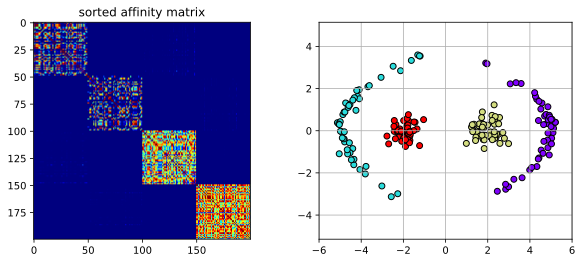

In [26]:
scfig

# Sensitivity to gamma
- gamma controls which structures are important
  - small gamma - far away points are still considered similar
  - large gamma - close points are not considered similar

In [27]:
X = Xtie
axbox = axboxtie

scfig2 = plt.figure(figsize=(9,16))
for i,g in enumerate([0.01, 1.0, 10.0, 100.0]):
    sc = cluster.SpectralClustering(n_clusters=4, affinity='rbf', gamma=g,
                                assign_labels='discretize', n_jobs=-1)
    Y = sc.fit_predict(X)

    plt.subplot(4,2,2*i+1)
    ii = argsort(Y)
    plt.imshow(sc.affinity_matrix_[ix_(ii,ii)], interpolation='nearest', cmap='jet')
    plt.title('gamma=' + str(g))
    plt.subplot(4,2,2*i+2)
    plot_clusters(sc, axbox, X, Y, rbow, rbow2)
    
plt.close()

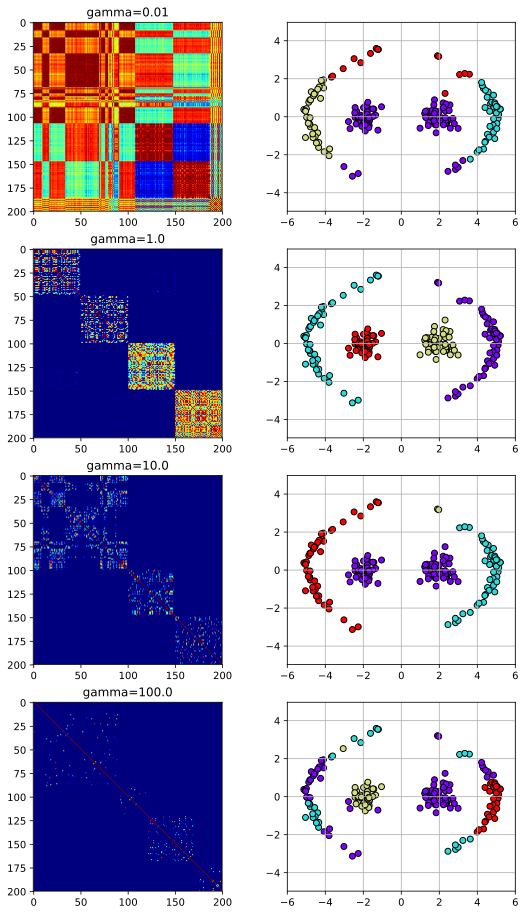

In [28]:
scfig2

# Another Example

In [29]:
X = Xcirc[::2,:]
axbox = axboxcirc
graphfig2 = plt.figure()
plot_sc_graph(X, 10.0, axbox)
plt.close()

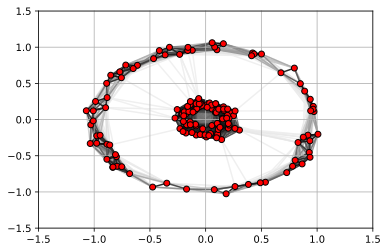

In [30]:
graphfig2

In [31]:
X = Xcirc
axbox = axboxcirc
sc = cluster.SpectralClustering(n_clusters=2, affinity='rbf',
                                gamma=10, assign_labels='discretize', n_jobs=-1)
Y = sc.fit_predict(X)

ii = argsort(Y)

scfig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(sc.affinity_matrix_[ix_(ii,ii)], interpolation='nearest', cmap='jet')
plt.title('sorted affinity matrix')

plt.subplot(1,2,2)
plot_clusters(sc, axbox, X, Y, rbow, rbow2)
plt.close()

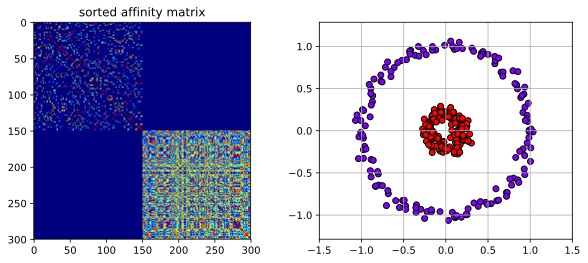

In [32]:
scfig

# DBSCAN
  - "Density-Based Spatial Clustering of Applications with Noise"
    - Assumption: clusters are regions of high density of points separated by areas of low density.
    - Algorithm Idea: 
      - Find a _core_ point of high density.
      - Recursively label the neighbors as core points.
      - Neighbors that are not core samples are called _boundary_ or _non-core_ points.
      - Points that are not boundary and not core points are _outliers_.

- Define two parameters:
  - `eps`:  the maximum distance to be considered a neighbor.
  - `min_samples`: the minimum number of neighbors (including point itself) to be considered a core sample.
<center><img src="imgs/dbscan.jpg"></center>

In [34]:
X = Xtie
axbox = axboxtie

In [35]:
# eps = the max distance to be considered a neighbor
# min_samples = min number of neighbors to be a core sample
dbs = cluster.DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)
Y = dbs.fit_predict(X)

# labels: -1 means outlier
print(Y)

# indices for core samples
print(dbs.core_sample_indices_)

[-1  0  0  0  0  0  0  0 -1  0  0  0 -1 -1  0  0 -1  0  0  0  0  0  0 -1
  0 -1  0  0 -1 -1 -1  0  0  0 -1  0  0  0  0  0 -1  0  0  0 -1  0  0  0
  0 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  2  2  2  2  2 -1  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  3  3  3  3 -1  3 -1  3  3  3  3  3  3  3 -1 -1  3  3
  3  3  3 -1  3  3  3  3  3  3 -1  3  3  3  3 -1  3  3  3  3  3 -1  3  3
 -1  3  3 -1  3 -1  3  3]
[  1   2   3   4   6   7   9  10  11  14  15  19  20  21  22  24  26  27
  31  32  33  35  36  37  38  39  41  43  45  46  47  48  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  68  69  70  71  72
  73  75  76  77  78  79  80  81  82  83  84  85  86  87  89  90  91  92
  93  94  95  96  97  99 100 101 102 103 104 106 107 108 109 110 112 113
 114 115 116 117 118 119 

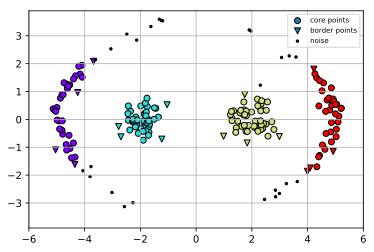

In [36]:
plot_clusters(dbs, axbox, X, Y, rbow, rbow2)
plt.legend(fontsize=7);

- Effect of `eps`
  - smaller `eps` - high density required to make a single cluster
  - larger `eps` - encourages collapsing of clusters
  - `min_samples` is 5.

In [37]:
dbfig = plt.figure(figsize=(9,8))
for i,e in enumerate([0.1, 0.5, 1.0, 5.0]):
    dbs = cluster.DBSCAN(eps=e, min_samples=5, n_jobs=-1)
    Y = dbs.fit_predict(X)
    plt.subplot(2,2,i+1)
    newK = plot_clusters(dbs, axbox, X, Y, rbow, rbow2)
    plt.title("eps=%g; K=%d" % (e,newK[0]))
plt.close()

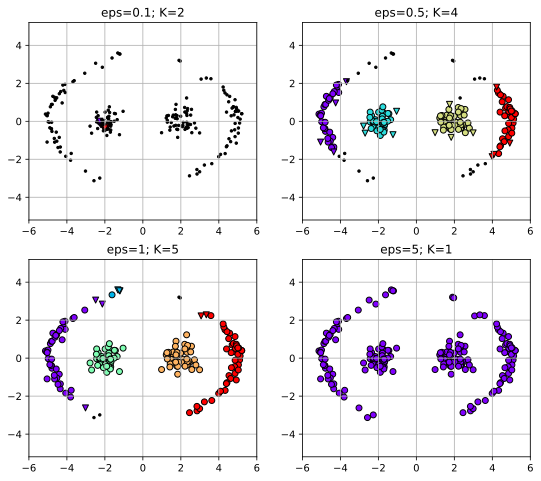

In [38]:
dbfig

- Effect of `min_samples`
  - smaller `min_samples` -  encourages forming small clusters
  - larger `min_samples` - forms clusters only in very high-density regions.
  - `eps` is 0.5 here.

In [39]:
dbfig = plt.figure(figsize=(9,8))
for i,m in enumerate([2, 5, 10, 15]):
    dbs = cluster.DBSCAN(eps=0.5, min_samples=m, n_jobs=-1)
    Y = dbs.fit_predict(X)
    plt.subplot(2,2,i+1)
    newK = plot_clusters(dbs, axbox, X, Y, rbow, rbow2)
    plt.title("min_samples={}; K={}".format(m,newK[0]))
plt.close()

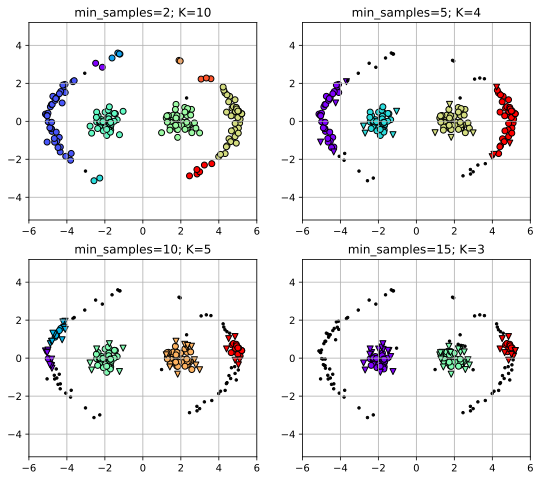

In [40]:
dbfig

# Clustering Summary
- **Goal:** given set of input vectors $\{\mathbf{x}_i\}_{i=1}^n$, with $\mathbf{x}_i\in\mathbb{R}^d$, group similar $x_i$ together into clusters.
  - estimate a cluster center, which represents the data points in that cluster.
  - predict the cluster for a new data point.
  
<table style="font-size:9pt;">
<tr>
<th>Name</th>
<th>Cluster Shape</th>
<th>Principle</th>
<th>Advantages</th>
<th>Disadvantages</th>
</tr>
<tr>
<td>K-Means</td>
<td>circular</td>
<td>minimize distance to cluster center</td>
<td>- scalable (MiniBatchKMeans)</td>
<td>- sensitive to initialization; could get bad solutions due to local minima.<br>- need to choose K.</td>
</tr>
<tr>
<td>Gaussian Mixture Model</td>
<td>elliptical</td>
<td>maximum likelihood</td>
<td>- elliptical cluster shapes.</td>
<td>- sensitive to initialization; could get bad solutions due to local minima.<br>- need to choose K.</td>
</tr>
<tr>
<td>Dirichlet Process GMM</td>
<td>elliptical</td>
<td>maximum likelihood</td>
<td>- automatically selects K via concentration parameter.</td>
<td>- can be slow.<br>- sensitive to initialization; could get bad solutions due to local minima.</td>
</tr>
<tr>
<td>Mean-Shift</td>
<td>concentrated compact</td>
<td>move towards local mean</td>
<td>- automatically selects K via bandwidth parameter.</td>
<td>- can be slow.</td>
</tr>
<tr>
<td>Spectral clustering</td>
<td>irregular shapes</td>
<td>graph-based</td>
<td>- can handle clusters of any shape, as long as connected.</td>
<td>- need to choose K.<br>- cannot assign novel points to a cluster.<br>- can be slow (kernel matrix)</td>
</tr>
<tr>
<td>DBSCAN</td>
<td>irregular shapes</td>
<td>density-based</td>
<td>- can handle clusters of any shape, as densely sampled.<br>- can detect outliers</td>
<td>- sensitive to parameters<br>- cannot assign novel points to a cluster.</td>
</tr>
</table>

# Other Things
- _Feature normalization_
  - feature normalization is typically required clustering.
  - e.g., algorithms based on Euclidean distance (Kmeans, Mean-Shift, Spectral Clustering)